In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [ ]:
'''Position limits for the newly introduced products:

- `VOLCANIC_ROCK`: 400

`VOLCANIC_ROCK_VOUCHER_9500` :

- Position Limit: 200
- Strike Price: 9,500 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_9750` :

- Position Limit: 200
- Strike Price: 9,750 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10000` :

- Position Limit: 200
- Strike Price: 10,000 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10250` :

- Position Limit: 200
- Strike Price: 10,250 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1

`VOLCANIC_ROCK_VOUCHER_10500` :

- Position Limit: 200
- Strike Price: 10,500 SeaShells
- Expiration deadline: 7 days (1 round = 1 day) starting from round 1'''


class Product:
    ROCK = 'VOLCANIC_ROCK'
    VOUCHER_9500 = 'VOLCANIC_ROCK_VOUCHER_9500'
    VOUCHER_9750 = 'VOLCANIC_ROCK_VOUCHER_9750'
    VOUCHER_10000 = 'VOLCANIC_ROCK_VOUCHER_10000'
    VOUCHER_10250 = 'VOLCANIC_ROCK_VOUCHER_10250'
    VOUCHER_10500 = 'VOLCANIC_ROCK_VOUCHER_10500'

position_limits = {
    Product.ROCK: 400,
    Product.VOUCHER_9500: 200,
    Product.VOUCHER_9750: 200,
    Product.VOUCHER_10000: 200,
    Product.VOUCHER_10250: 200,
    Product.VOUCHER_10500: 200
}

In [3]:
start_day = 2

prices = pd.concat([pd.read_csv(f'round5/prices_round_5_day_{i}.csv', sep=';') for i in range(2, 5)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round5/trades_round_5_day_{i}.csv', sep=';') for i in range(2, 5)], ignore_index=True)
observations = []
for day in range(2, 5):
    odf = pd.read_csv(f'round5/observations_round_5_day_{day}.csv')
    odf['day'] = day
    observations.append(odf)
observations = pd.concat(observations, ignore_index=True)

prices['time'] = prices['timestamp'] + (prices['day'] - start_day) * 1_000_000

In [4]:
prices['swmid'] = (prices['bid_price_1'] * prices['ask_volume_1'] + prices['ask_price_1'] * prices['bid_volume_1']) / (prices['ask_volume_1'] + prices['bid_volume_1'])

In [ ]:
rock = prices[prices["product"] == Product.ROCK].reset_index(drop=True).copy()
voucher_9500 = prices[prices["product"] == Product.VOUCHER_9500].reset_index(drop=True).copy()
voucher_9750 = prices[prices["product"] == Product.VOUCHER_9750].reset_index(drop=True).copy()
voucher_10000 = prices[prices["product"] == Product.VOUCHER_10000].reset_index(drop=True).copy()
voucher_10250 = prices[prices["product"] == Product.VOUCHER_10250].reset_index(drop=True).copy()
voucher_10500 = prices[prices["product"] == Product.VOUCHER_10500].reset_index(drop=True).copy()

In [ ]:
[rock, voucher_9500, voucher_9750, voucher_10000, voucher_10250, voucher_10500] = [df.rename(columns={'ask_price_1': 'ask_price', 'bid_price_1': 'bid_price', 'ask_volume_1': 'ask_volume', 'bid_volume_1': 'bid_volume'}) for df in [rock, voucher_9500, voucher_9750, voucher_10000, voucher_10250, voucher_10500]]

In [ ]:
rock = rock.drop(columns=['product'], axis=1).rename(columns={col: col + '_rock' for col in rock.columns if col not in ['timestamp', 'day']})
voucher_9500 = voucher_9500.drop(columns=['product'], axis=1).rename(columns={col: col + '_voucher9500' for col in voucher_9500.columns if col not in ['timestamp', 'day']})
voucher_9750 = voucher_9750.drop(columns=['product'], axis=1).rename(columns={col: col + '_voucher9750' for col in voucher_9750.columns if col not in ['timestamp', 'day']})
voucher_10000 = voucher_10000.drop(columns=['product'], axis=1).rename(columns={col: col + '_voucher10000' for col in voucher_10000.columns if col not in ['timestamp', 'day']})
voucher_10250 = voucher_10250.drop(columns=['product'], axis=1).rename(columns={col: col + '_voucher10250' for col in voucher_10250.columns if col not in ['timestamp', 'day']})
voucher_10500 = voucher_10500.drop(columns=['product'], axis=1).rename(columns={col: col + '_voucher10500' for col in voucher_10500.columns if col not in ['timestamp', 'day']})

In [ ]:
# join croissants, james, djembes, basket1, basket2 on timestamp
mk = rock.merge(voucher_9500, on=['day', 'timestamp'])
mk = mk.merge(voucher_9750, on=['day', 'timestamp'])
mk = mk.merge(voucher_10000, on=['day', 'timestamp'])
mk = mk.merge(voucher_10250, on=['day', 'timestamp'])
mk = mk.merge(voucher_10500, on=['day', 'timestamp'])
mk

In [ ]:
from scipy.stats import norm

def realized_vol(df, window, step_size):
    df[f'log_return_{step_size}'] = np.log(df['mid_price_rock'].to_numpy()/df['mid_price_rock'].shift(step_size).to_numpy())
    dt = step_size / 250 / 10000 
    df[f'realized_vol_{step_size}'] = df[f'log_return_{step_size}'].rolling(window=window).apply(lambda x: np.mean(x[::step_size]**2) / dt)
    df[f'realized_vol_{step_size}'] = np.sqrt(df[f'realized_vol_{step_size}'].to_numpy())
    return df

def black_scholes_call(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot / strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    d2 = d1 - volatility * np.sqrt(time_to_expiry)
    call_price = (spot * norm.cdf(d1) - strike * norm.cdf(d2))
    return call_price

day  timestamp  bid_price_1_PICNIC_BASKET2  \
0        2          0                     30094.0   
1        2        100                     30096.0   
2        2        200                     30092.0   
3        2        300                     30093.0   
4        2        400                     30096.0   
...    ...        ...                         ...   
29995    4     999500                     30382.0   
29996    4     999600                     30383.0   
29997    4     999700                     30382.0   
29998    4     999800                     30382.0   
29999    4     999900                     30382.0   

       bid_volume_1_PICNIC_BASKET2  bid_price_2_PICNIC_BASKET2  \
0                             11.0                     30093.0   
1                              3.0                     30093.0   
2                             15.0                     30091.0   
3                              1.0                     30092.0   
4                             46.0                         NaN   
...                            ...                         ...   
29995                          1.0                     30381.0   
29996                          2.0                     30382.0   
29997                         35.0                         NaN   
29998                         22.0                     30381.0   
29999                         11.0                     30381.0   

       bid_volume_2_PICNIC_BASKET2  bid_price_3_PICNIC_BASKET2  \
0                             27.0                         NaN   
1                             39.0                         NaN   
2                             20.0                         NaN   
3                             33.0                         NaN   
4                              NaN                         NaN   
...                            ...                         ...   
29995                         41.0                         NaN   
29996                         34.0                         NaN   
29997                          NaN                         NaN   
29998                         28.0                         NaN   
29999                         30.0                         NaN   

       bid_volume_3_PICNIC_BASKET2  ask_price_1_PICNIC_BASKET2  \
0                              NaN                     30099.0   
1                              NaN                     30099.0   
2                              NaN                     30097.0   
3                              NaN                     30098.0   
4                              NaN                     30103.0   
...                            ...                         ...   
29995                          NaN                     30387.0   
29996                          NaN                     30388.0   
29997                          NaN                     30388.0   
29998                          NaN                     30388.0   
29999                          NaN                     30387.0   

       ask_volume_1_PICNIC_BASKET2  ask_price_2_PICNIC_BASKET2  \
0                              1.0                     30100.0   
1                             19.0                     30100.0   
2                              2.0                     30098.0   
3                              1.0                     30099.0   
4                             46.0                         NaN   
...                            ...                         ...   
29995                         15.0                     30388.0   
29996                          2.0                     30389.0   
29997                         16.0                     30389.0   
29998                         50.0                         NaN   
29999                          1.0                     30388.0   

       ask_volume_2_PICNIC_BASKET2  ask_price_3_PICNIC_BASKET2  \
0                             37.0                         NaN   
1                             20.0                         NaN   


In [ ]:
from scipy.optimize import brentq

def implied_volatility_neg(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    implied_vol = brentq(equation, -2.0, 3.0, xtol=1e-10)
    return implied_vol

def implied_volatility(call_price, spot, strike, time_to_expiry):
    # Define the equation where the root is the implied volatility
    def equation(volatility):
        estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
        return estimated_price - call_price

    # Using Brent's method to find the root of the equation
    implied_vol = brentq(equation, 1e-10, 3.0, xtol=1e-10)
    return implied_vol

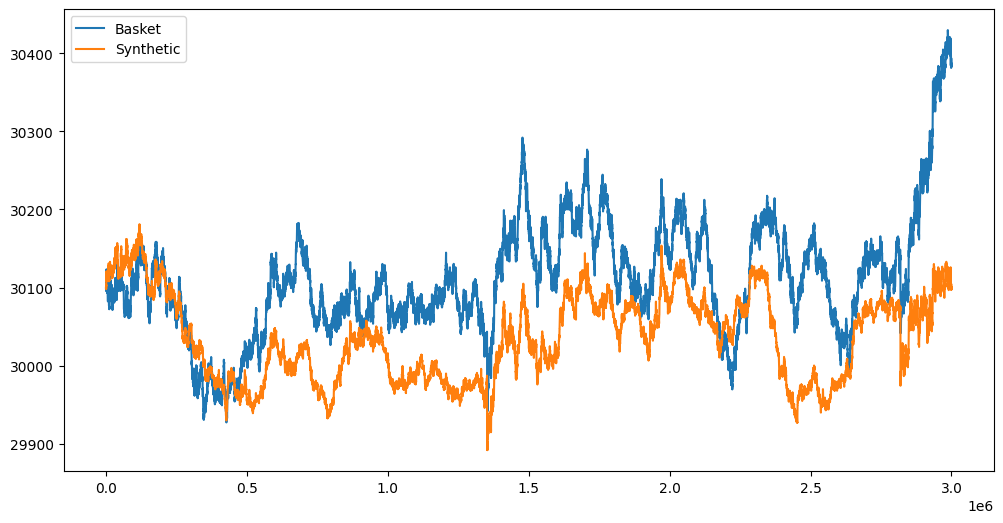

In [ ]:
def delta(spot, strike, time_to_expiry, volatility):
    d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility ** 2) * time_to_expiry) / (volatility * np.sqrt(time_to_expiry))
    return norm.cdf(d1)



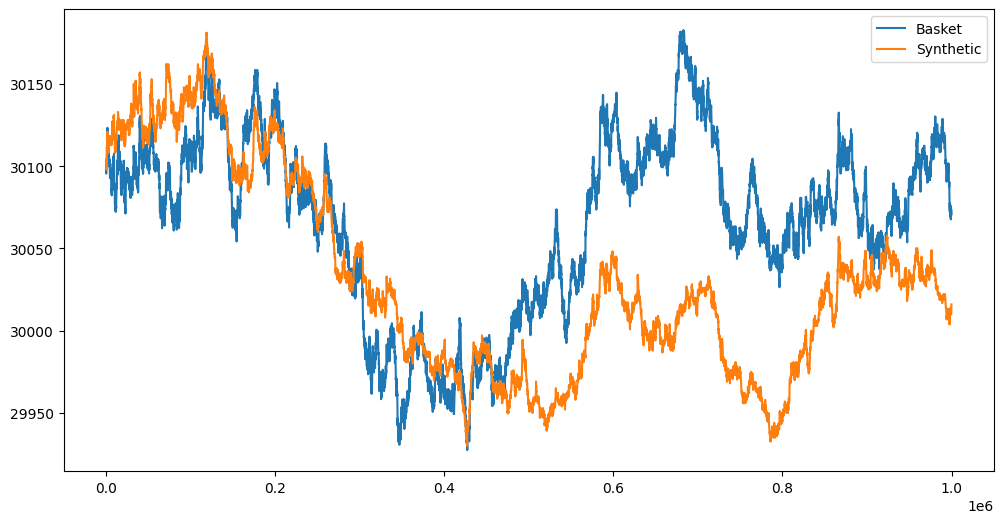

In [ ]:
strike = 10_000

mk['tte'] = (8 - mk['day'] - mk['timestamp'] / 1_000_000) / 250
mk['iv'] = mk.apply(lambda row: implied_volatility(row[f'mid_price_voucher{strike}'], row['mid_price_rock'], strike, row['tte']), axis=1)
mk['m_t'] = np.log(strike / mk['mid_price_rock']) / mk['tte']

In [56]:
len(spread_weights)

5

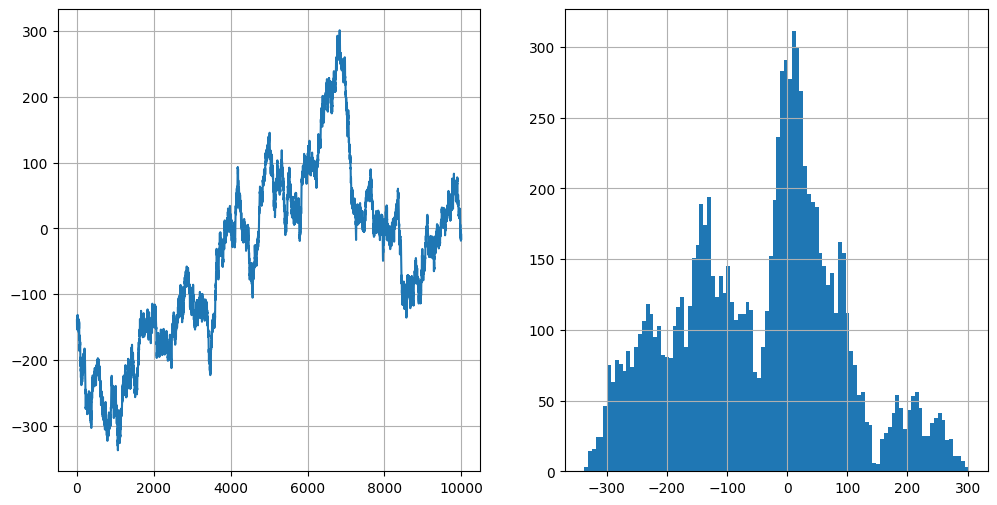

In [57]:
synth = 4
prod = Product.DJEMBES
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[f'swmid_spread{synth}'].plot()
# df[f'swmid_{prod}'].plot()
plt.grid()
plt.subplot(1, 2, 2)
df[f'swmid_spread{synth}'].hist(bins=100)
plt.show()

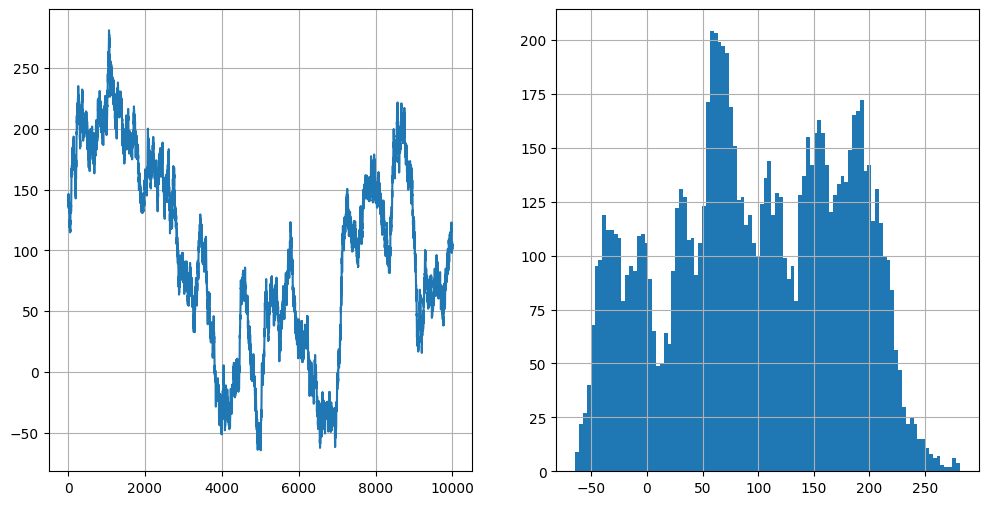

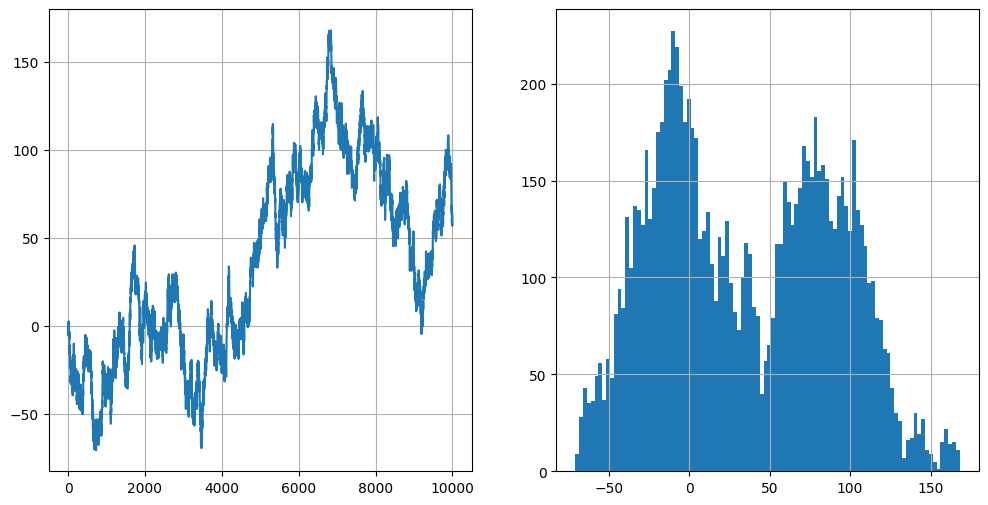

In [58]:
synth = 0
prod = Product.PB1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[f'swmid_spread{synth}'].plot()
plt.grid()
plt.subplot(1, 2, 2)
df[f'swmid_spread{synth}'].hist(bins=100)
plt.show()

synth = 1
prod = Product.PB2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df[f'swmid_spread{synth}'].plot()
plt.grid()
plt.subplot(1, 2, 2)
df[f'swmid_spread{synth}'].hist(bins=100)
plt.show()

In [43]:
# mk[f'swmid_spread{1}'].mean()
mk[f'swmid_spread{1}'].std()

np.float64(64.01153549556177)

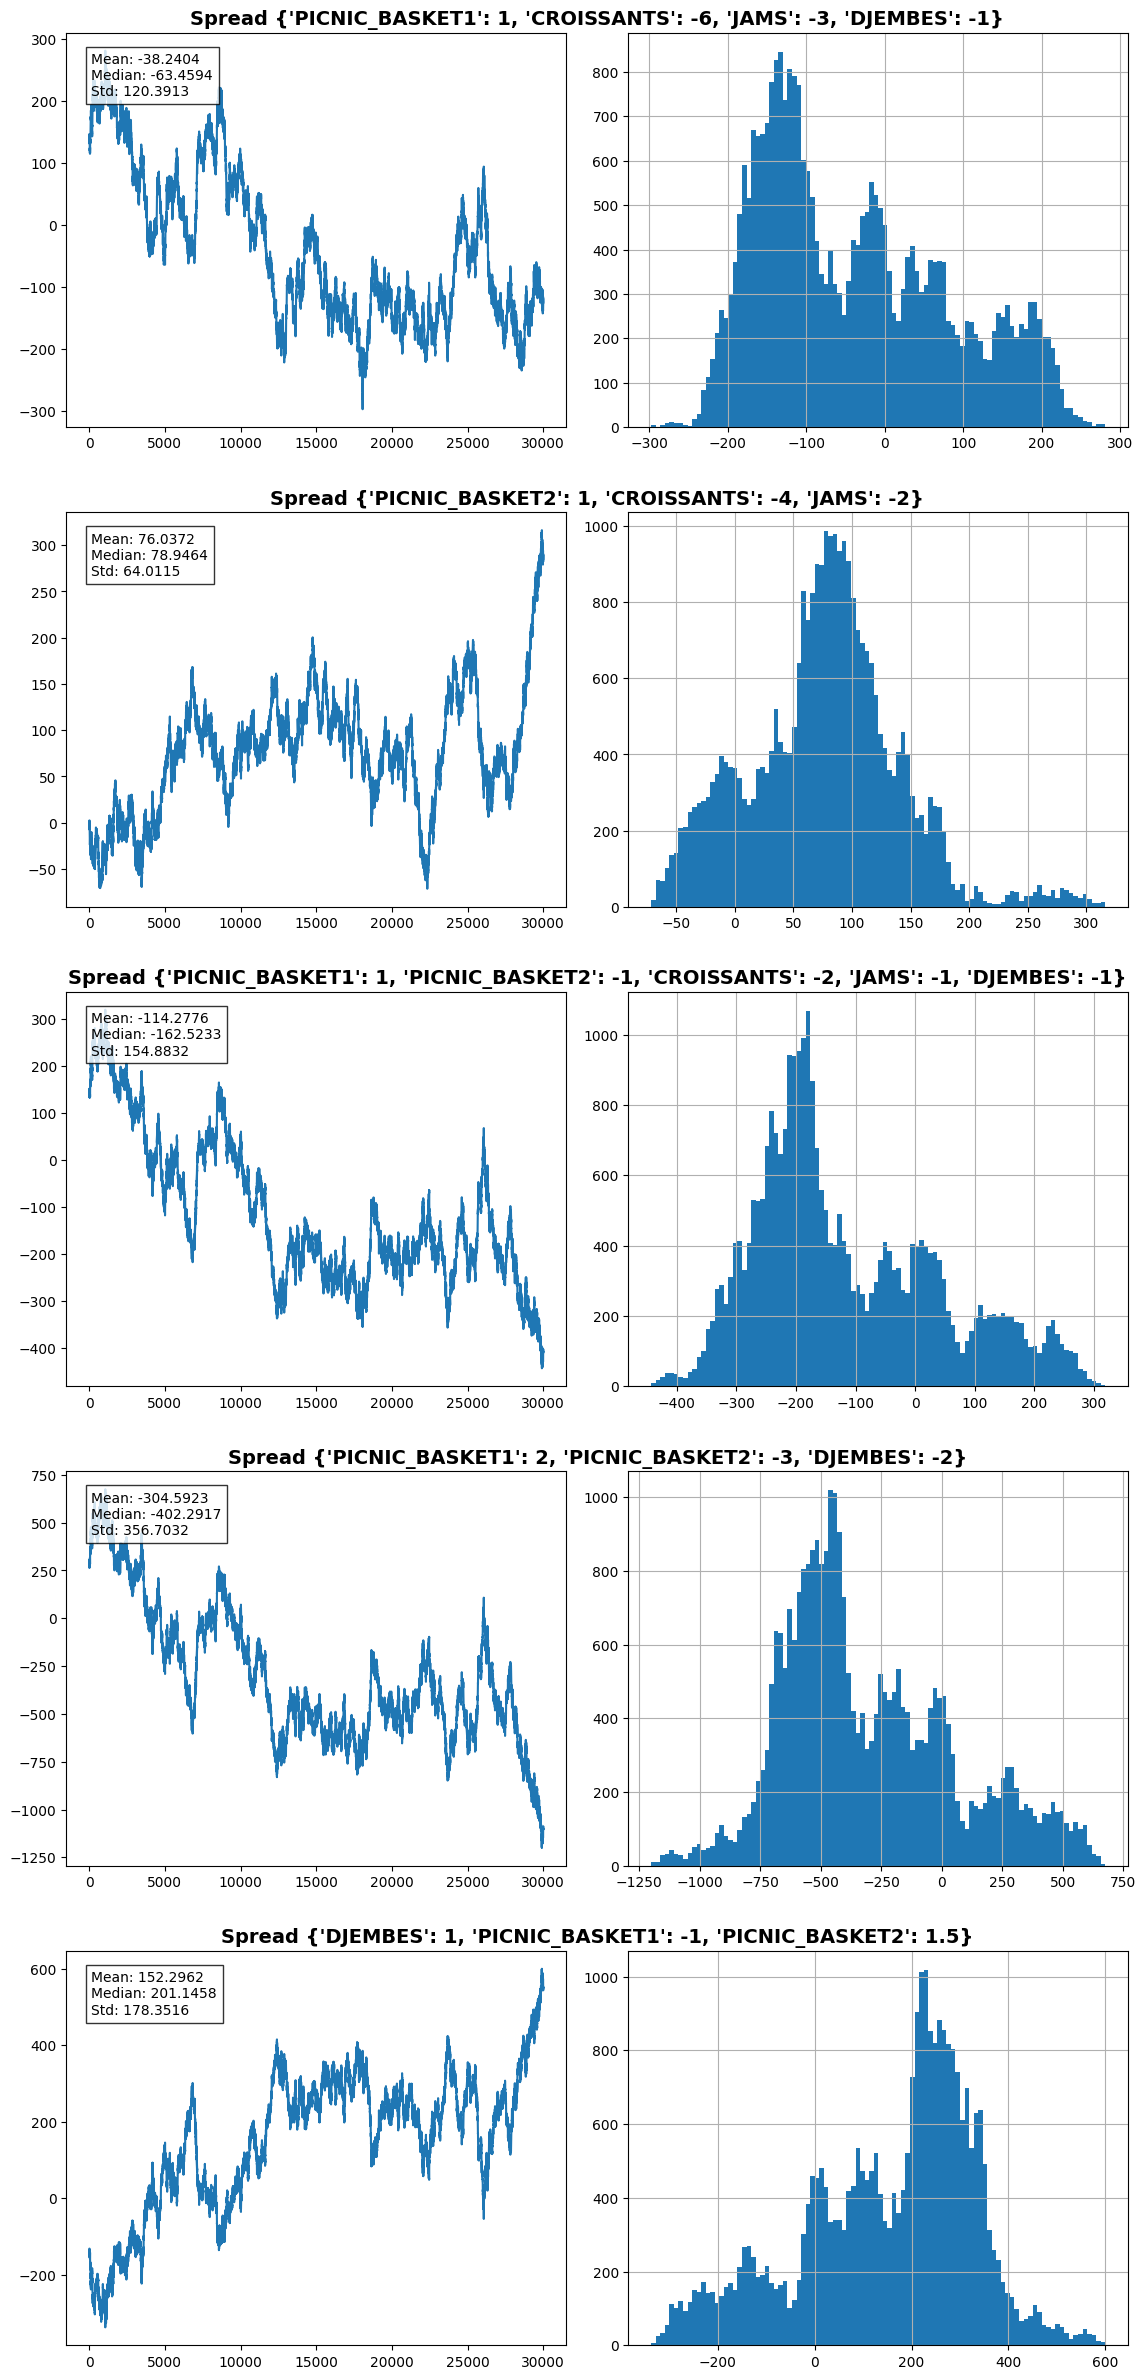

In [78]:
n = len(spread_weights)
fig = plt.figure(figsize=(12, 25))

# Calculate the number of rows and columns needed
rows = n
cols = 2

for i in range(n):
    # Create a subplot for the row title (invisible axes)
    row_title_ax = fig.add_subplot(rows, 1, i+1, frameon=False)
    row_title_ax.set_title(f'Spread {spread_weights[i]}', fontsize=14, fontweight='bold')
    row_title_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    row_title_ax.grid(False)
    
    # Line plot
    ax1 = fig.add_subplot(rows, cols, i*cols+1)
    mk[f'swmid_spread{i}'].plot(ax=ax1)
    # ax1.set_title('Time Series')
    
    # Add stats to line plot
    mean_val = mk[f"swmid_spread{i}"].mean()
    median_val = mk[f"swmid_spread{i}"].median()
    std_val = mk[f"swmid_spread{i}"].std()
    
    stats_text = f'Mean: {mean_val:.4f}\nMedian: {median_val:.4f}\nStd: {std_val:.4f}'
    ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    # Histogram
    ax2 = fig.add_subplot(rows, cols, i*cols+2)
    mk[f'swmid_spread{i}'].hist(bins=100, ax=ax2)
    # ax2.set_title('Histogram')

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for row titles
plt.grid(True)
plt.show()

In [80]:
# Calculate the number of rows and columns needed
rows = n
cols = 2

for i in range(n):
    print(f'Spread {spread_weights[i]}')
    mean_val = mk[f"swmid_spread{i}"].mean()
    median_val = mk[f"swmid_spread{i}"].median()
    std_val = mk[f"swmid_spread{i}"].std()
    
    stats_text = f'Mean: {mean_val:.4f}; Median: {median_val:.4f}; Std: {std_val:.4f}'
    print(stats_text)

Spread {'PICNIC_BASKET1': 1, 'CROISSANTS': -6, 'JAMS': -3, 'DJEMBES': -1}
Mean: -38.2404; Median: -63.4594; Std: 120.3913
Spread {'PICNIC_BASKET2': 1, 'CROISSANTS': -4, 'JAMS': -2}
Mean: 76.0372; Median: 78.9464; Std: 64.0115
Spread {'PICNIC_BASKET1': 1, 'PICNIC_BASKET2': -1, 'CROISSANTS': -2, 'JAMS': -1, 'DJEMBES': -1}
Mean: -114.2776; Median: -162.5233; Std: 154.8832
Spread {'PICNIC_BASKET1': 2, 'PICNIC_BASKET2': -3, 'DJEMBES': -2}
Mean: -304.5923; Median: -402.2917; Std: 356.7032
Spread {'DJEMBES': 1, 'PICNIC_BASKET1': -1, 'PICNIC_BASKET2': 1.5}
Mean: 152.2962; Median: 201.1458; Std: 178.3516


In [ ]:
'''
Spread {'PICNIC_BASKET1': 1, 'CROISSANTS': -6, 'JAMS': -3, 'DJEMBES': -1}
Mean: -38.2404; Median: -63.4594; Std: 120.3913
Spread {'PICNIC_BASKET2': 1, 'CROISSANTS': -4, 'JAMS': -2}
Mean: 76.0372; Median: 78.9464; Std: 64.0115
Spread {'PICNIC_BASKET1': 1, 'PICNIC_BASKET2': -1, 'CROISSANTS': -2, 'JAMS': -1, 'DJEMBES': -1}
Mean: -114.2776; Median: -162.5233; Std: 154.8832
Spread {'PICNIC_BASKET1': 2, 'PICNIC_BASKET2': -3, 'DJEMBES': -2}
Mean: -304.5923; Median: -402.2917; Std: 356.7032
Spread {'DJEMBES': 1, 'PICNIC_BASKET1': -1, 'PICNIC_BASKET2': 1.5}
Mean: 152.2962; Median: 201.1458; Std: 178.3516
'''

# [
#     {
#         'spread_weights': {'PICNIC_BASKET1': 1, 'CROISSANTS': -6, 'JAMS': -3, 'DJEMBES': -1},
#         'mean': -38.2404,
#         'median': -63.4594,
#         'std': 120.3913
#     },
#     {
#         'spread_weights': {'PICNIC_BASKET2': 1, 'CROISSANTS': -4, 'JAMS': -2},
#         'mean': 76.0372,
#         'median': 78.9464,
#         'std': 64.0115
#     },
#     {
#         'spread_weights': {'PICNIC_BASKET1': 1, 'PICNIC_BASKET2': -1, 'CROISSANTS': -2, 'JAMS': -1, 'DJEMBES': -1},
#         'mean': -114.2776,
#         'median': -162.5233,
#         'std': 154.8832
#     },
#     {
#         'spread_weights': {'PICNIC_BASKET1': 2, 'PICNIC_BASKET2': -3, 'DJEMBES': -2},
#         'mean': -304.5923,
#         'median': -402.2917,
#         'std': 356.7032
#     },
#     {
#         'spread_weights': {'DJEMBES': 1, 'PICNIC_BASKET1': -1, 'PICNIC_BASKET2': 1.5},
#         'mean': 152.2962,
#         'median': 201.1458,
#         'std': 178.3516
#     }
# ]

<Axes: >

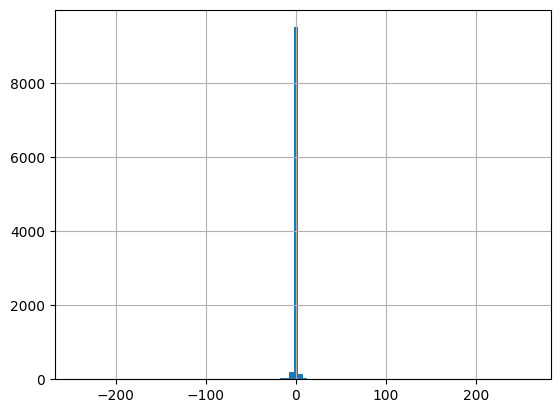

In [102]:
df['swmid_spread1'].pct_change(20).hist(bins=100)
df['swmid_synth1'].pct_change(20).hist(bins=100)

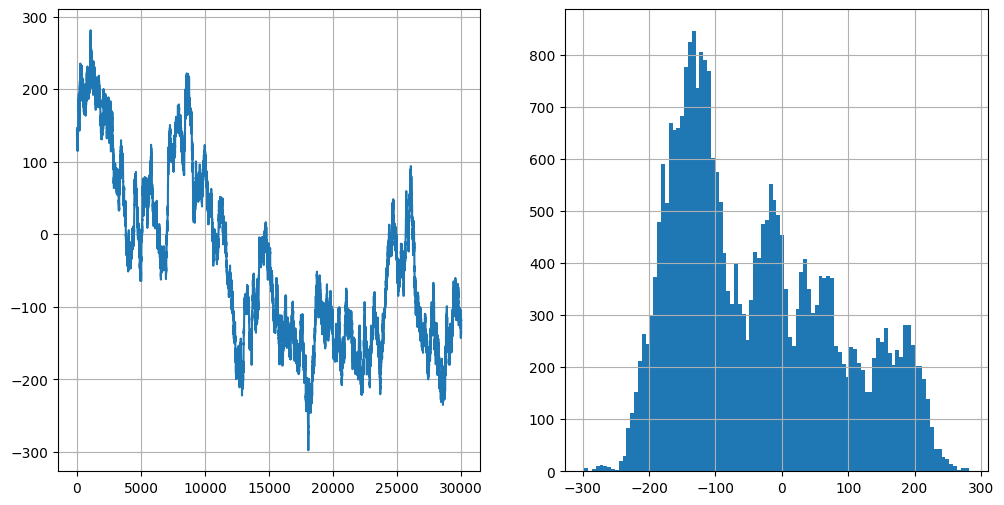

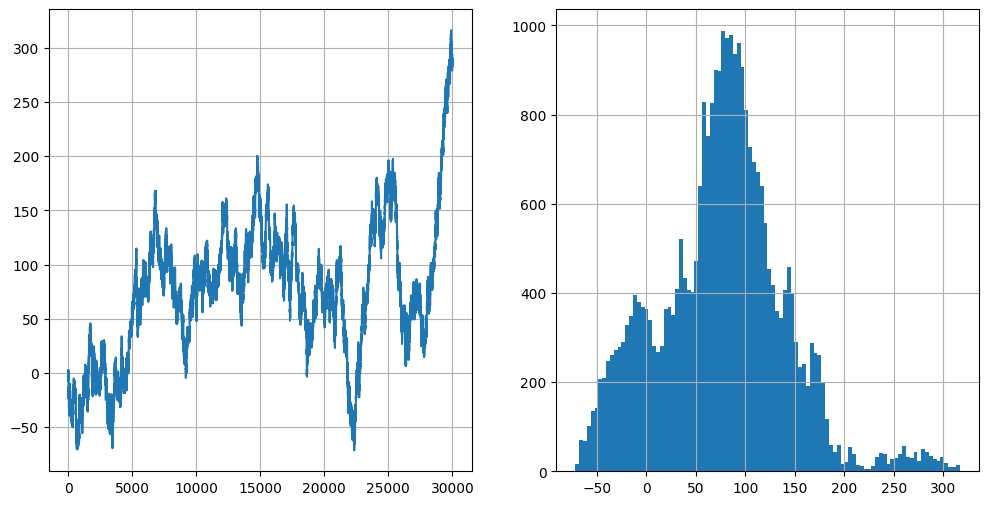

In [91]:
synth = 0
prod = Product.PB1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
(mk[f'swmid_{prod}'] - mk[f'swmid_synth{synth}']).plot()
plt.grid()
plt.subplot(1, 2, 2)
(mk[f'swmid_{prod}'] - mk[f'swmid_synth{synth}']).hist(bins=100)
plt.show()

synth = 1
prod = Product.PB2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
(mk[f'swmid_{prod}'] - mk[f'swmid_synth{synth}']).plot()
plt.grid()
plt.subplot(1, 2, 2)
(mk[f'swmid_{prod}'] - mk[f'swmid_synth{synth}']).hist(bins=100)
plt.show()

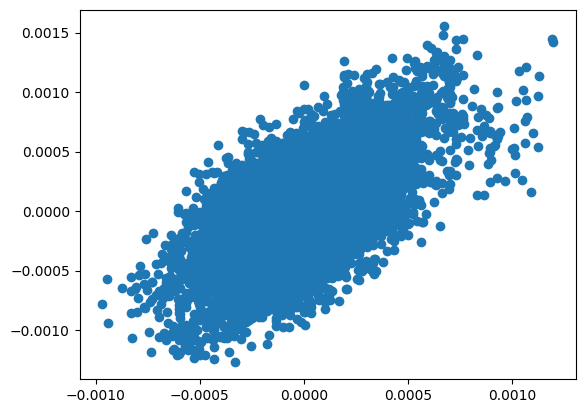

In [47]:
'''
it's not spreads that we trade, maybe return in synthetic predicts returns on component

if it's not pct_change thenn it might simply be raw price? how do we plot the price without multicollinearity?
maybe we can do diff instead?
'''

df = mk[mk['day'] == 2].copy()

synth = 1
prod = Product.PB2

period = 20
shift = 1

x = df[f'swmid_synth{synth}'].pct_change(period).shift(1)
y = df['swmid_' + prod].pct_change(period)

# x = df[f'swmid_synth{synth}'].diff(period).shift(shift)
# y = df['swmid_' + prod].diff(period)

# # Remove outliers for both x and y that are more than 3 standard deviations away
# x_mean, x_std = x.mean(), x.std()
# y_mean, y_std = y.mean(), y.std()

# std_filter = 10

# x_filtered = x[(x > x_mean - std_filter * x_std) & (x < x_mean + std_filter * x_std)]
# y_filtered = y[(y > y_mean - std_filter * y_std) & (y < y_mean + std_filter * y_std)]

# # Align x and y to ensure they have the same indices after filtering
# common_indices = x_filtered.index.intersection(y_filtered.index)
# x = x_filtered.loc[common_indices]
# y = y_filtered.loc[common_indices]

plt.scatter(x, y)
plt.show()

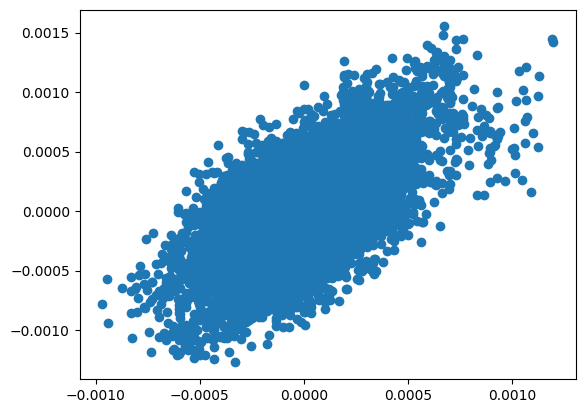

In [48]:
'''
it's not spreads that we trade, maybe return in synthetic predicts returns on component

if it's not pct_change thenn it might simply be raw price? how do we plot the price without multicollinearity?
maybe we can do diff instead?
'''

df = mk[mk['day'] == 2].copy()

synth = 1
prod = Product.PB2

period = 20
shift = 1

x = df[f'swmid_synth{synth}'].pct_change(period).shift(1)
y = df['swmid_' + prod].pct_change(period)

# x = df[f'swmid_synth{synth}'].diff(period).shift(shift)
# y = df['swmid_' + prod].diff(period)

# # Remove outliers for both x and y that are more than 3 standard deviations away
# x_mean, x_std = x.mean(), x.std()
# y_mean, y_std = y.mean(), y.std()

# std_filter = 10

# x_filtered = x[(x > x_mean - std_filter * x_std) & (x < x_mean + std_filter * x_std)]
# y_filtered = y[(y > y_mean - std_filter * y_std) & (y < y_mean + std_filter * y_std)]

# # Align x and y to ensure they have the same indices after filtering
# common_indices = x_filtered.index.intersection(y_filtered.index)
# x = x_filtered.loc[common_indices]
# y = y_filtered.loc[common_indices]

plt.scatter(x, y)
plt.show()

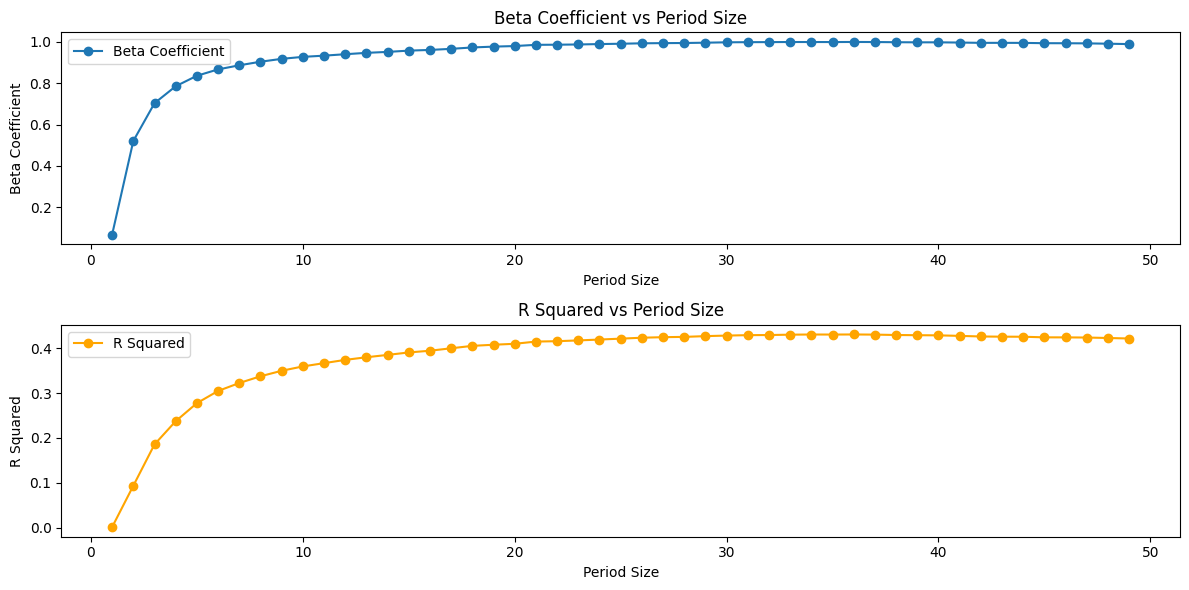

In [49]:
df = mk[mk['day'] == 2].copy()

from sklearn.linear_model import LinearRegression

synth = 1
prod = Product.PB2

periods = range(1, 50)

betas = []
r_squared = []

for period in periods:
    x = df[f'swmid_synth{synth}'].pct_change(period).shift(1).dropna()
    y = df['swmid_' + prod].pct_change(period).dropna()

    idx = x.index.intersection(y.index)

    X = x.loc[idx].values.reshape((-1, 1))
    y = y.loc[idx].values

    model = LinearRegression()
    model.fit(X, y)

    betas.append(model.coef_[0])
    r_squared.append(model.score(X, y))

# Plot beta coefficients and R-squared values
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(periods, betas, label='Beta Coefficient', marker='o')
plt.title('Beta Coefficient vs Period Size')
plt.xlabel('Period Size')
plt.ylabel('Beta Coefficient')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(periods, r_squared, label='R Squared', marker='o', color='orange')
plt.title('R Squared vs Period Size')
plt.xlabel('Period Size')
plt.ylabel('R Squared')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
x = df[f'swmid_synth{synth}'].pct_change(20).shift(1).dropna()
y = df['swmid_' + prod].pct_change(20).dropna()

idx = x.index.intersection(y.index)

X = x.loc[idx].values.reshape((-1, 1))
y = y.loc[idx].values

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
model.coef_

array([0.97967075])

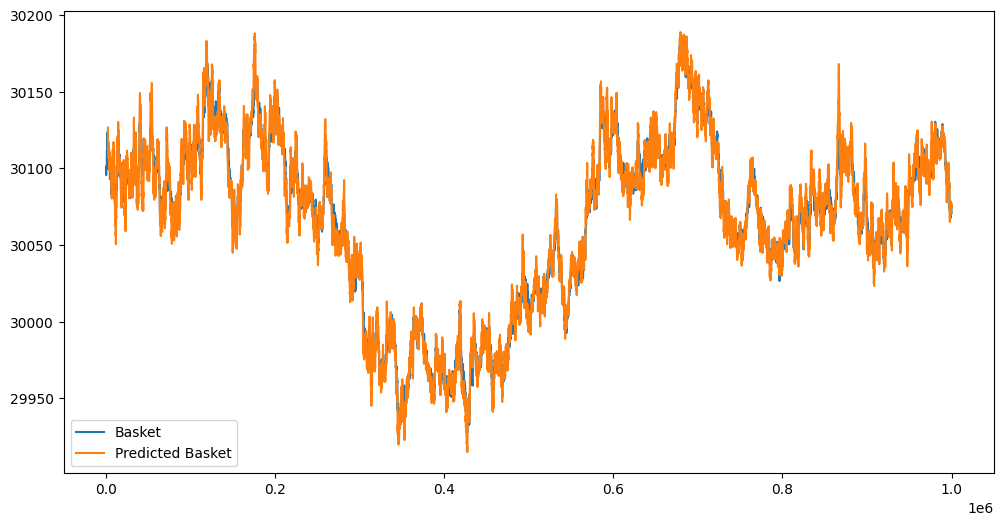

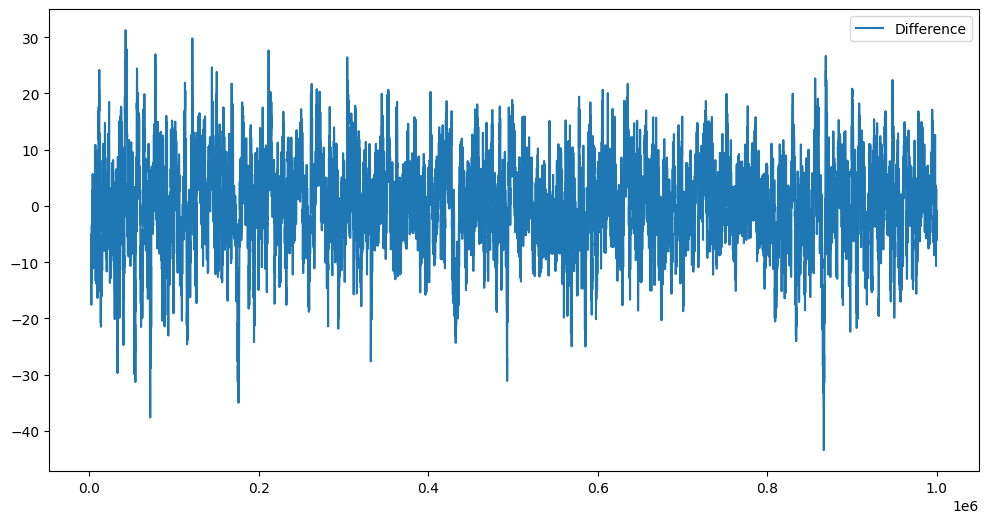

In [ ]:
beta = 0.97967075
basket_pct = df['swmid_synth1'].pct_change(20).shift(1) * beta
basket_predt1 = df['swmid_' + Product.PB2] * (1 + basket_pct)
plt.figure(figsize=(12, 6))
# plt.plot(df['time'], df['swmid_' + Product.PB2], label='Basket')
plt.plot(df['time'], basket_predt1.shift(1), label='Predicted Basket')
plt.plot(df['time'], basket_predt1.shift(1), label='Predicted Basket')
plt.legend()
plt.show()

diff = df['swmid_' + Product.PB2] - basket_predt1.shift(1)
plt.figure(figsize=(12, 6))
plt.plot(df['time'], diff, label='Difference')
plt.legend()
plt.show()

In [ ]:
betas[1 + 20]

'''
equation:

basket2 fractional change at t+1 = synth fractional change at t * 0.97967075

'''

np.float64(0.9861970898099717)

In [132]:
y

1      -7.223737e-05
2       8.884106e-08
3      -3.029480e-05
4       1.329102e-04
5       5.814050e-05
            ...     
9995   -2.602821e-05
9996   -5.160367e-05
9997   -5.550140e-06
9998    9.773646e-05
9999    3.760675e-06
Name: swmid_PICNIC_BASKET2, Length: 9999, dtype: float64

In [ ]:
df = mk[mk['day'] == -1]

In [ ]:
q = (mk['day'] == -1)
synth = 2

mk[f'synth{synth}_sma'] = mk[f'swmid_synth{synth}'].rolling(window=60).mean()
mk[f'synth{synth}_std'] = mk[f'swmid_synth{synth}'].rolling(window=50).std()
mk[f'synth{synth}_zscore'] = (mk[f'swmid_synth{synth}'] - mk[f'synth{synth}_sma']) / mk[f'synth{synth}_std']

fig = go.Figure()

fig.add_trace(go.Scatter(x=mk.loc[q, 'timestamp'], y=mk.loc[q, f'swmid_synth{synth}'], mode='lines', name=f'SWMid Synth{synth}'))
# fig.add_trace(go.Scatter(x=mk.loc[q, 'timestamp'], y=mk.loc[q, f'synth{synth}_sma'], mode='lines', name=f'Synth{synth} SMA'))
# fig.add_trace(go.Scatter(x=mk.loc[q, 'timestamp'], y=mk.loc[q, f'synth{synth}_zscore'], mode='lines', name=f'Synth{synth} Z-Score', yaxis='y2'))

# fig.update_layout(yaxis2=dict(title='Z Score', overlaying='y', side='right'))
# fig.update_layout(title=f'Synth{synth} Z-Score', xaxis_title='Timestamp', yaxis_title='Z-Score')
fig.show()

In [116]:
mk['swmid_synth0'].pct_change()

0              NaN
1        -0.401754
2         0.315008
3        -0.844639
4       -22.000000
           ...    
29995     0.012438
29996     0.008193
29997    -0.044025
29998     0.090620
29999     0.004756
Name: swmid_synth0, Length: 30000, dtype: float64

In [127]:
q = mk['day'] == 1

fig = go.Figure()
fig.add_trace(go.Scatter(x=mk[q]['timestamp'], y=mk[q]['swmid_synth0'].pct_change(), mode='lines', name='SWMid Synth0'))
fig.update_layout(title='SWMid Synth0 vs Timestamp', xaxis_title='Timestamp', yaxis_title='SWMid Synth0')
fig.show()

In [129]:
mk['swmid_synthbask'] = 6 * mk['swmid_CROISSANTS'] + 3 * mk['swmid_JAMS'] + 1 * mk['swmid_DJEMBES'] + 1

In [ ]:
# plot of swmid_synthbask
fig = go.Figure()
fig.add_trace(go.Scatter(x=mk[q]['timestamp'], y=mk[q]['swmid_synthbask'], mode='lines', name='SWMid SynthBask'))
fig.add_trace(go.Scatter(x=mk[q]['timestamp'], y=mk[q]['swmid_PICNIC_BASKET1'], mode='lines', name='Basket1'))
fig.add_trace(go.Scatter(x=mk[q]['timestamp'], y=[mk[q]['swmid_synthbask'].mean()] * len(mk[q]['timestamp']), mode='lines', name='Mean'))
fig.update_layout(title='SWMid SynthBask vs Timestamp', xaxis_title='Timestamp', yaxis_title='SWMid SynthBask')
fig.show()

In [138]:
# plot pct change of synthbasket change against basket1 change
fig = go.Figure()
fig.add_trace(go.Scatter(x=mk[q]['swmid_synthbask'].pct_change(), y=mk[q]['swmid_PICNIC_BASKET1'].pct_change().shift(30), mode='markers', name='SWMid SynthBask vs Basket1'))
fig.update_layout(title='SWMid SynthBask vs Basket1', xaxis_title='SWMid SynthBask', yaxis_title='Basket1')
fig.show()

ValueError: supplied range of [-inf, inf] is not finite

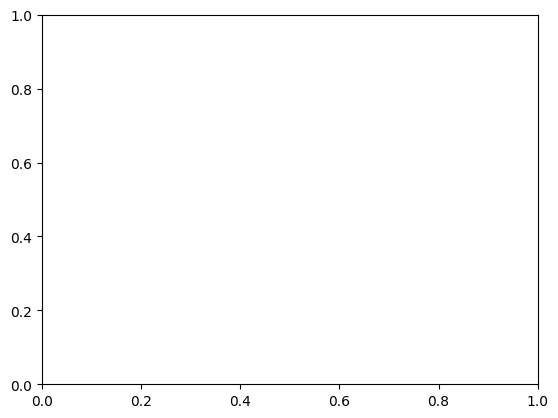

In [ ]:
mk[q]['swmid_synth0'].pct_change()

In [97]:
mk.groupby('day')['swmid_synth1'].describe()

count       mean        std         min        25%        50%  \
day                                                                    
-1   10000.0  58.090589  51.870394 -102.119048  39.654814  66.000000   
 0   10000.0  -3.858777  55.128494 -122.736842 -43.843318 -12.569952   
 1   10000.0  36.469181  55.148739 -105.892208  -9.250658  43.500000   

           75%         max  
day                         
-1   93.547980  149.593496  
 0   34.421825  134.450292  
 1   73.500000  148.642281

In [98]:
mk.groupby('day')['swmid_synth2'].describe()

count       mean        std         min        25%        50%  \
day                                                                    
-1   10000.0  11.963393  65.660621 -146.694838 -39.860788   8.126541   
 0   10000.0  47.781266  63.231961  -96.094686   4.384151  54.859748   
 1   10000.0  -4.112082  98.243357 -196.706897 -88.781515 -19.954685   

           75%         max  
day                         
-1   64.468781  168.944444  
 0   92.462005  208.071429  
 1   89.563709  199.308610

In [99]:
mk.groupby('day')['swmid_synth0'].describe()

count       mean        std         min        25%        50%  \
day                                                                    
-1   10000.0  70.053983  78.667021 -175.564951  19.450462  80.236501   
 0   10000.0  43.922489  82.788898 -130.704588 -10.010850  44.000000   
 1   10000.0  32.357099  89.161706 -197.155172 -19.490476  23.159344   

            75%         max  
day                          
-1   120.500000  250.277618  
 0   110.404215  222.000000  
 1   102.056772  230.111570

In [100]:
mk.groupby('day')['swmid_synth3'].describe()

count       mean         std         min         25%         50%  \
day                                                                       
-1   10000.0 -34.163803  146.841805 -362.000000 -153.854933  -28.114379   
 0   10000.0  99.421310  139.280776 -300.000000  -12.131410  133.083882   
 1   10000.0 -44.693345  226.130655 -535.406593 -241.000000  -79.238662   

            75%         max  
day                          
-1    86.966169  321.388889  
 0   202.862575  414.666667  
 1   132.779388  402.397129

In [183]:
mk['spread1_zscore'].describe()

count    9701.000000
mean        0.252552
std         3.484058
min       -10.157279
25%        -2.210694
50%         0.050785
75%         2.689442
max        17.789029
Name: spread1_zscore, dtype: float64

day0 spread1 zscore summary
count    9701.000000
mean        0.322448
std         3.353061
min        -9.998620
25%        -2.123352
50%         0.228565
75%         2.708731
max        11.672497
Name: spread1_zscore, dtype: float64

day1
day0 spread1 zscore summary
count    9701.000000
mean        0.322448
std         3.353061
min        -9.998620
25%        -2.123352
50%         0.228565
75%         2.708731
max        11.672497
Name: spread1_zscore, dtype: float64

day1



In [ ]:
spread = mk[['timestamp', 'swmid_spread1']].copy()
spread.rename(columns={'swmid_spread1': 'swmid'}, inplace=True)
spread['spread'] = spread['swmid'].copy()

spread2 = mk[['timestamp', 'swmid_spread2']].copy()
spread2.rename(columns={'swmid_spread2': 'swmid'}, inplace=True)
spread2['spread'] = spread2['swmid'].copy()

In [152]:
from tqdm import tqdm

def cross_spread(cash, quantity):
    return cash - abs(quantity) * 10

def backtest(spread, thresh, target_position, std_window, sma_window, verbose=False):
    cash = 0
    position = 0
    pnl_hist = []
    position_hist = []
    cash_hist = []
    spread[f'std{std_window}'] = spread['spread'].rolling(window=std_window).std()
    spread[f'sma{sma_window}'] = spread['spread'].rolling(window=sma_window).mean()
    z_score = (spread['spread'].to_numpy() - spread[f'sma{sma_window}']) / spread[f'std{std_window}'].to_numpy()
    spread['spread_z'] = z_score
    for index, row in spread.iterrows():
        if index == 0:
            continue
        swmid = row['swmid']
        
        if row['spread_z'] > thresh and position != -target_position:
        
            
            quantity = -target_position - position
            cash -= (-target_position - position) * swmid
            cash = cross_spread(cash, quantity)
            position = -target_position
            
            if verbose:
                print(f"SELL {quantity} AT PRICE {swmid} AT TIME {row['timestamp']}")
        
        if row['spread_z'] < -thresh and position != target_position:
            quantity = target_position - position
            cash -= (target_position - position) * swmid
            cash = cross_spread(cash, quantity)
            position = target_position
            
            if verbose:
                print(f"BUY {quantity} FOR PRICE {swmid} AT TIME {row['timestamp']}")
    
        position_hist.append(position)
        cash_hist.append(cash)
        pnl_hist.append(cash + position * swmid)
        
    if verbose:
        print(f"PNL: {pnl_hist[-1]}")
        
    return pnl_hist


In [163]:
position_opt = [60]
thresh_opt = [1,2,3,5,6,7,7.5,8,9,10,15,20,25]
std_window_opt = [10,20,25,30,35,40,50]
sma_window_opt = [10,20,25,30,35,40,50,75, 100, 125, 150, 200, 300, 500]
opt = []
for thresh in tqdm(thresh_opt): 
    for std_window in std_window_opt: 
        for sma_window in sma_window_opt:
            for position in position_opt:
                pnl = backtest(spread2, thresh, position, std_window, sma_window)
                opt.append({"thresh": thresh, "position": position, "std_window": std_window, "sma_window": sma_window, "pnl": pnl})
#                 print("="*80)
#                 print(f"Thresh: {thresh}, Position: {position}, Std Window: {std_window}, PnL: {pnl[-1]}")
#                 print("="*80)

100%|██████████| 13/13 [02:55<00:00, 13.46s/it]


In [164]:
spread['spread'].mean()

np.float64(43.922489021349016)

In [165]:
opt.sort(key=lambda x: x['pnl'][-1], reverse=True)
top_3_pnl = opt[:3]
pnl_graph = top_3_pnl[0]['pnl']

fig = go.Figure()
fig.add_trace(go.Scatter(x=spread.index, y=pnl_graph, mode='lines', name='PnL'))
fig.show()

In [167]:
top_3_pnl = opt[:3]
top_pnl_params = top_3_pnl[0]
for params in top_3_pnl:
    print(f"thresh: {params['thresh']}, std_window: {params['std_window']}, sma_window: {params['sma_window']}, pnl: {params['pnl'][-1]}")

thresh: 8, std_window: 25, sma_window: 125, pnl: 12486.761331593298
thresh: 10, std_window: 25, sma_window: 150, pnl: 11953.98168192296
thresh: 5, std_window: 20, sma_window: 35, pnl: 10530.0


spread1
thresh: 7, std_window: 35, sma_window: 125, pnl: 24212.82352941198
thresh: 7, std_window: 50, sma_window: 200, pnl: 21864.714339038765
thresh: 5, std_window: 50, sma_window: 125, pnl: 21512.814052237227

spread2
thresh: 8, std_window: 25, sma_window: 125, pnl: 12486.761331593298
thresh: 10, std_window: 25, sma_window: 150, pnl: 11953.98168192296
thresh: 5, std_window: 20, sma_window: 35, pnl: 10530.0

In [166]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=spread.index, y=pnl_graph, mode='lines', name='PnL'))
# fig.show()

for o in opt[:5]:
    # graph the pnl
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=spread.index, y=o['pnl'], mode='lines', name='PnL'))
    fig.update_layout(title=f"Thresh: {o['thresh']}, Position: {o['position']}, Std Window: {o['std_window']}, Sma Window: {o['sma_window']}, PnL: {o['pnl'][-1]}")
    fig.show()
    